In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import torch
from google.protobuf import text_format
from utils import simplevis
from pytorch.train import build_network
from protos import pipeline_pb2
from utils import config_tool

## Read Config file

In [38]:
config_path = "/home/niels/workspaces/second-ws/src/second.pytorch/second/models/model_people/pipeline.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
config_tool.change_detection_range_v2(model_cfg, [-10, -10, 10, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [39]:
ckpt_path = "/home/niels/workspaces/second-ws/src/second.pytorch/second/models/model_people/voxelnet-9285.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

[ 21 400 400]


## Generate Anchors

In [40]:
model_cfg

network_class_name: "VoxelNet"
voxel_generator {
  voxel_size: 0.05000000074505806
  voxel_size: 0.05000000074505806
  voxel_size: 0.15000000596046448
  point_cloud_range: -10.0
  point_cloud_range: -10.0
  point_cloud_range: -2.5
  point_cloud_range: 10.0
  point_cloud_range: 10.0
  point_cloud_range: 0.5
  max_number_of_points_per_voxel: 5
}
voxel_feature_extractor {
  module_class_name: "SimpleVoxel"
  num_filters: 16
  num_input_features: 4
}
middle_feature_extractor {
  module_class_name: "SpMiddleFHDPeople"
  num_input_features: 4
  downsample_factor: 4
}
rpn {
  module_class_name: "RPNV2"
  layer_nums: 5
  layer_strides: 1
  num_filters: 128
  upsample_strides: 1.0
  num_upsample_filters: 128
  num_groups: 32
  num_input_features: 128
}
num_point_features: 4
use_sigmoid_score: true
loss {
  localization_loss {
    weighted_smooth_l1 {
      sigma: 3.0
      code_weight: 1.0
      code_weight: 1.0
      code_weight: 1.0
      code_weight: 1.0
      code_weight: 1.0
      code_wei

In [41]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

In [42]:
grid_size

array([400, 400,  20])

## Read KITTI infos
you can load your custom point cloud.

In [43]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [44]:
len(infos)
info_path

'/home/niels/data/kitti/kitti_infos_val.pkl'

In [45]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
print(v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
voxels, coords, num_points = voxel_generator.generate(points, max_voxels=90000)


print(voxels.shape)
print(anchors.shape)

# add batch idx to coords
coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
coords = torch.tensor(coords, dtype=torch.int32, device=device)
num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

/home/niels/data/kitti/training/velodyne/001140.bin
(11016, 5, 4)
torch.Size([1, 40000, 7])


## Detection

In [46]:
example = {
    "anchors": anchors,
    "voxels": voxels,
    "num_points": num_points,
    "coordinates": coords,
}


In [47]:
pred = net(example)[0]

## Simple Vis

In [48]:
boxes_lidar = pred["box3d_lidar"].detach().cpu().numpy()
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)

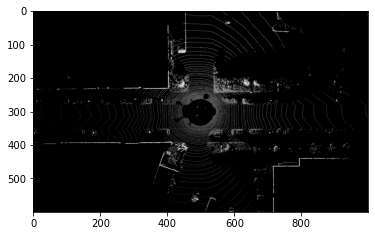

In [49]:
plt.imshow(bev_map)